# BLG556E - Digital Solution for Smart Cities

Halit Uyanık - 504202506<br>
Kadir Şinas Kaynak - 504191525


In [1]:
import os
import sys
import urllib.request
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from utilities.PreProcessingUtil import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [2]:
#read pollutant values
# A N by T feature matrix, which describes the (f_1, .., f_T) speed records over T timesteps for the N sensors.
dfPollutant = pd.read_excel(
     "datasets/pollutants/mecidiyekoy.xlsx",
     engine='openpyxl',
     parse_dates=True,
     thousands='.'
)



In [3]:
#remove index column
dfPollutant = dfPollutant.iloc[: , 1:] 

#dataset info
time_len, num_pol = dfPollutant.shape
print("No. of pollution:", num_pol-1, "\nNo of timesteps:", time_len)

No. of pollution: 6 
No of timesteps: 71495


In [4]:
dfPollutant = dfPollutant.iloc[-20000:,:]

In [5]:
dfPollutant = preprocessing(dfPollutant)
dfPollutant = dfPollutant['PM10 ( µg/m3 )']

/Users/deneme/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
max_speed = dfPollutant.max()
min_speed = dfPollutant.min()
print(max_speed,min_speed)

434.0299987792969 3.109999895095825


In [8]:
# Train - Test split
def train_test_split(data, train_portion):
    time_len = data.shape[0]
    train_size = int(time_len * train_portion)
    print(train_size)
    train_data = np.array(data.iloc[:train_size])
    test_data = np.array(data.iloc[train_size:])
    return train_data, test_data

# Scaling
def scale_data(train_data, test_data):
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [9]:
train_rate = 0.8
train_data, test_data = train_test_split(dfPollutant, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)
train_scaled, test_scaled = scale_data(train_data, test_data)

16000
Train data:  (16000,)
Test data:  (4000,)


In [10]:
# This value represents the past feature window size
seq_len = 2
# This value represents how far ahead we want to predict
pre_len = 1
# Data for LSTM is prepared using the Sliding Window approach
# Sliding windows are applied for each sensor
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[0] - int(seq_len + pre_len - 1)):
        a = train_data[i : i + seq_len + pre_len]
        trainX.append(a[:seq_len])
        trainY.append(a[-1])

    for i in range(test_data.shape[0] - int(seq_len + pre_len - 1)):
        b = test_data[i : i + seq_len + pre_len]
        testX.append(b[:seq_len])
        testY.append(b[-1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [11]:
# We expect to see features of seq_len window size for each sensor 
# and labels as the pre_len ahead output
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(15998, 2)
(15998,)
(3998, 2)
(3998,)


In [12]:
subsequences = 2
timesteps = trainX.shape[1]//subsequences
X_train_series_sub = trainX.reshape((trainX.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = testX.reshape((testX.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (15998, 2, 1, 1)
Validation set shape (3998, 2, 1, 1)


In [152]:
lstm_layer_sizes = 50
lstm_activations = "relu"
cnn_activations = "relu"
loss='mae'
optimizer='adam'
n_epochs=50
batch_size=72
shuffle=False
verbose=2
# design network
model_cnn_lstm = Sequential()
model_cnn_lstm.add(
    TimeDistributed(Conv1D(filters=64, kernel_size=1, activation=cnn_activations), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3]))
    )
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(lstm_layer_sizes, activation=lstm_activations))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss=loss, optimizer=optimizer)
# fit network
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, trainY, validation_data=(X_valid_series_sub, testY), epochs=n_epochs, verbose=verbose)

Epoch 1/50
500/500 - 1s - loss: 0.0276 - val_loss: 0.0216
Epoch 2/50
500/500 - 1s - loss: 0.0209 - val_loss: 0.0183
Epoch 3/50
500/500 - 1s - loss: 0.0202 - val_loss: 0.0183
Epoch 4/50
500/500 - 1s - loss: 0.0199 - val_loss: 0.0177
Epoch 5/50
500/500 - 1s - loss: 0.0199 - val_loss: 0.0177
Epoch 6/50
500/500 - 1s - loss: 0.0200 - val_loss: 0.0174
Epoch 7/50
500/500 - 1s - loss: 0.0199 - val_loss: 0.0176
Epoch 8/50
500/500 - 1s - loss: 0.0198 - val_loss: 0.0175
Epoch 9/50
500/500 - 1s - loss: 0.0199 - val_loss: 0.0177
Epoch 10/50
500/500 - 1s - loss: 0.0196 - val_loss: 0.0173
Epoch 11/50
500/500 - 1s - loss: 0.0198 - val_loss: 0.0172
Epoch 12/50
500/500 - 1s - loss: 0.0196 - val_loss: 0.0179
Epoch 13/50
500/500 - 1s - loss: 0.0197 - val_loss: 0.0172
Epoch 14/50
500/500 - 1s - loss: 0.0198 - val_loss: 0.0174
Epoch 15/50
500/500 - 1s - loss: 0.0197 - val_loss: 0.0170
Epoch 16/50
500/500 - 1s - loss: 0.0196 - val_loss: 0.0177
Epoch 17/50
500/500 - 1s - loss: 0.0195 - val_loss: 0.0177
Epoch 

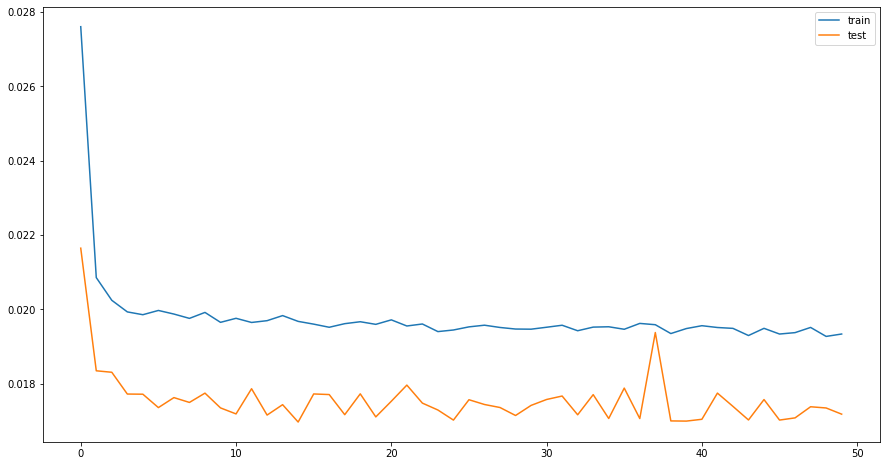

In [153]:
# plot history
fig = plt.figure(figsize=(15, 8))
pyplot.plot(cnn_lstm_history.history['loss'], label='train')
pyplot.plot(cnn_lstm_history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [154]:
# Actual prediction
yhat = model_cnn_lstm.predict(X_valid_series_sub)

In [155]:
print(yhat[:10])
print(testY[:10])

[[0.07543543]
 [0.07182892]
 [0.07271443]
 [0.08045755]
 [0.11912547]
 [0.09451062]
 [0.07359491]
 [0.07300147]
 [0.08311884]
 [0.09283995]]
[0.06757634 0.06859741 0.07528079 0.11401188 0.0944955  0.07247285
 0.06975772 0.07890096 0.09161793 0.13306414]


In [156]:
# We need to rescale the predictions because we applied normalization in the first place
## actual train and test values
test_rescref = np.array(testY * max_speed)

In [157]:
## Rescale model predicted values
test_rescpred = np.array((yhat) * max_speed)

In [158]:
print(test_rescref[:10])#actual
print(test_rescpred[:10])#predict

[29.33016  29.773335 32.674118 49.484577 41.01388  31.45539  30.276943
 34.24538  39.764927 57.753826]
[[32.741238]
 [31.175907]
 [31.560246]
 [34.92099 ]
 [51.70403 ]
 [41.020447]
 [31.9424  ]
 [31.68483 ]
 [36.07607 ]
 [40.295322]]


In [159]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(test_rescref, test_rescpred) #y_true, y_pred
rmse = sqrt(mean_squared_error(test_rescref, test_rescpred)) #y_true, y_pred
mase = sqrt(mean_absolute_error(test_rescref, test_rescpred)) #y_true, y_pred

print('------------------------------------------\n')
print('MSE:',mse)
print('RMSE:',rmse)
print('MASE:',mase)
print('------------------------------------------')

------------------------------------------

MSE: 164.3522
RMSE: 12.819992331087434
MASE: 2.7304614152932603
------------------------------------------


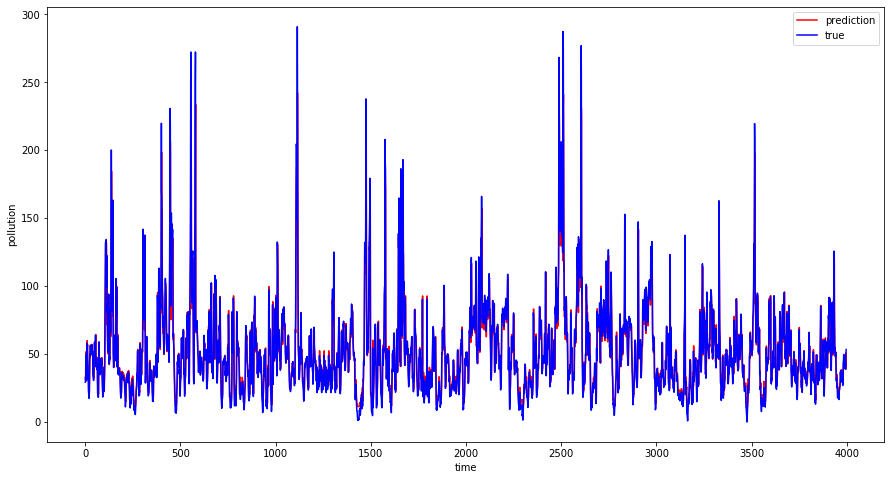

In [160]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:]
a_true = test_rescref[:]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("pollution")
plt.legend(loc="best", fontsize=10)
plt.show()

In [161]:
# Output all results to a sub-directory
import datetime
import pathlib
import os
path = pathlib.Path().absolute()
time = datetime.datetime.now().strftime("%m-%d-%Y %H-%M-%S")
result_dir = os.path.join (path, "experiments", time)
os.mkdir (result_dir)

# Create the result txt file
f = open(result_dir + "/" + "summary.txt", "w")

# Write experiment parameters
f.write ("---------Experiment Parameters--------")
f.write ("\nTrain-Test split rate: " + str(train_rate))
f.write ("\nNumber of epochs: " + str(n_epochs))
f.write ("\nBatch size: " + str(batch_size))
f.write ("\nShuffle during training: " + str(shuffle))
f.write ("\nVerbose: " + str(verbose))
f.write ("\n---------------------------")

# Write dataset details
f.write ("\n---------Dataset Details--------")
time_len= dfPollutant.shape[0]
f.write ("\nNo of timesteps:" + str(time_len))
f.write ("\nTrain data: " + str(train_data.shape))
f.write ("\nTest data: " + str(test_data.shape))

f.write ("\nTrain data X: " + str(trainX.shape))
f.write ("\nTrain data Y: " + str(trainY.shape))
f.write ("\nTest data X: " + str(testX.shape))
f.write ("\nTest data Y: " + str(testY.shape))
f.write ("\n---------------------------")

# Write model details
f.write ("\n---------Model Details--------")
f.write ("\nLSTM layer sizes: " + str(lstm_layer_sizes))
f.write ("\nLSTM activation functions: " + str(lstm_activations))
f.write ("\nCNN activation functions: " + str(cnn_activations))
f.write ("\nOptimizer: " + optimizer)
f.write ("\nLoss function: " + loss)
f.write ("\n---------------------------")

# Write results
f.write ('\nTest RMSE: %.3f' % rmse)

# Write visual outputs
fig.savefig (result_dir + "/" + "MAE-vs-Naive.png")
fig1.savefig (result_dir + "/" + "prediction-accuracy.png")

f.close ()